In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import FormatStrFormatter

In [2]:
import json
import os

In [3]:
# JSON file containing the results for this simulation run
results_file = "/home/brian/git_repos/results-analysis/configs/cv2x.json"

In [4]:
with open(results_file) as results_json:
    config = json.load(results_json)

In [5]:
# Markers to use for this run
markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h",
           "H", "+", "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [6]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning.
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width + 1, width):
        bins.append((low, low + width))
    return bins

In [7]:
def bin_fields(df, fields, bin_width=10, bin_quantity=49):
    """
    Bins multiple dfs into a single dictionary that can be used as an average for multiple fields across multiple
    runs
    :param df: dataframe to bin
    :param fields: fields to be binned.
    :param bin_width: width of each bin
    :param bin_quantity: total number of bins
    :return:
    """
    bins = create_bins(lower_bound=0, width=bin_width, quantity=bin_quantity)
    distances = []
    overall_fields = {}
    for interval in bins:
        upper_b = interval[1]
        distances.append(upper_b)

    for field in fields:
        print("{} being binned".format(field))
        overall_fields[field] = []

    overall_fields["distance"] = distances

    distance_col = config["results"]["distance"]

    for i in range(len(bins)):
        lower_b = bins[i][0]
        upper_b = bins[i][1]
        fields_temp = df[(df[distance_col] >= lower_b) & (df[distance_col] < upper_b)]
        for field in fields:
            if i < len(overall_fields[field]):
                overall_fields[field][i] = (fields_temp[field].mean() + overall_fields[field][i]) / 2
            else:
                overall_fields[field].append(fields_temp[field].mean())

    return overall_fields

In [8]:
def pdr_dist_individual(pdr, distances, label, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    ax.plot(distances, pdr, label=label, marker=markers[0], markevery=3)

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.legend(loc='lower right')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [9]:
def pdr_dist(pdrs, distances, labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(pdrs)):
        ax.plot(distances, pdrs[i], label=labels[i], marker=markers[i], markevery=3)

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.legend(loc='lower right')
    ax.tick_params(direction='in')
    
    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [10]:
def errors_dist_individual(distances, decoded, errors, error_labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    ax.plot(distances, decoded, label="Decoded", marker=self.markers[0], markevery=3)

    for i in range(len(errors)):
        ax.plot(distances, errors[i], label=error_labels[i], marker=self.markers[i+1], markevery=3)

    ax.legend(loc='center left')
    ax.set(xlabel='Distance (m)', ylabel='Messages Decoded')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()

    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [11]:
def errors_dist(distances, decoded, decoded_labels, errors, error_labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(decoded)):
        ax.plot(distances, decoded[i], label=decoded_labels[i], marker=self.markers[i], markevery=3)

        for j in range(len(errors[i])):
            ax.plot(distances, errors[i][j], label=error_labels[i][j], marker=self.markers[i + j])

    ax.legend(loc='center left')
    ax.set(xlabel='Distance (m)', ylabel='Messages Decoded')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))
    
    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

### CBR reporting

In [12]:
raw_data_folder = "/home/brian/git_repos/results-analysis/data/raw_data/cv2x/CBR-2"

In [13]:
first_file = True
merged_df = pd.DataFrame()
for file in os.listdir(raw_data_folder):
    if ".csv" in file:
        result_file = raw_data_folder + "/" + file
        if first_file:
            merged_df = pd.read_csv(result_file)
            first_file = False
        else:
            merged_df.append(pd.read_csv(result_file))

In [ ]:
merged_df.plot(x="Time", y="cbr", kind="line")

Need to do some more checks, in much better shape than it was but still some issues here.

- Primarily need to see why we have such a large fluctuation
- Also have to look at why it is a little low, though it also is an average of all vehicles.
- Might find min and max guys

In [76]:
node_23_df = merged_df[(merged_df["NodeID"] == 23) & (merged_df["cbr"] >= 0.0)]

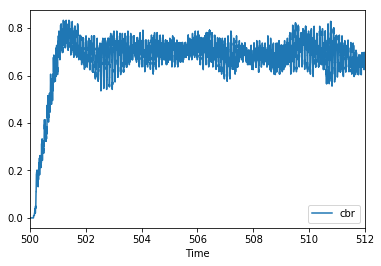

In [77]:
node_23_df.plot(x="Time", y="cbr", kind="line")

Wild fluctuation is a major issue, need to investigate what the story is there

Also extremely noisy, reducing the number of CBR reports is necessary, possibly sending it every 10ms or something like that will improve the quality. 100ms too wide a band.

In [78]:
reduced_merged_df = merged_df[(merged_df["Time"] >= 510) & (merged_df["Time"] <= 511)]

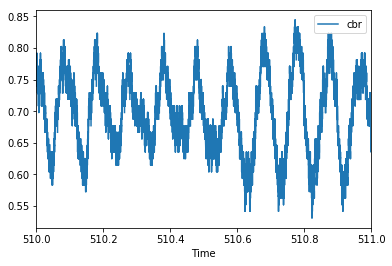

In [79]:
reduced_merged_df.plot(x="Time", y="cbr", kind="line")

In [80]:
print("mean: {}".format(reduced_merged_df["cbr"].mean()))
print("std: {}".format(reduced_merged_df["cbr"].std()))
print("median: {}".format(reduced_merged_df["cbr"].median()))

mean: 0.6966013966247454
std: 0.058623469402043264
median: 0.69791666666667


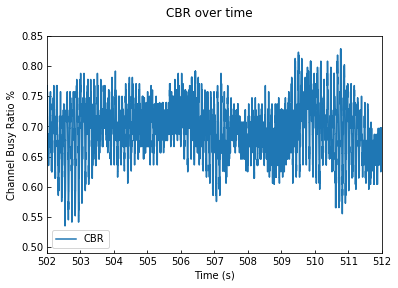

In [81]:
fig, ax = plt.subplots()

ax.plot(node_23_df["Time"], node_23_df["cbr"], label="CBR")

ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
ax.legend(loc='lower left')
ax.tick_params(direction='in')

ax.set_ylim([0.49, 0.85])
plt.yticks(np.arange(0.5, 0.86, step=0.05))

ax.set_xlim([min(node_23_df["Time"] + 2), (max(node_23_df["Time"]))])
plt.xticks(np.arange(min(node_23_df["Time"] + 2), (max(node_23_df["Time"]) + 1), step=1))

fig.suptitle("CBR over time", fontsize=12)
plt.savefig("CBR_sci_info_record.png", dpi=300)

### Channel Usage

In [21]:
merged_df = merged_df[merged_df["Time"] >= 502]

In [22]:
node_23_df = merged_df[(merged_df["NodeID"] == 23)]

In [23]:
# node_23_df = merged_df

In [24]:
node_23_df["subchannelReceived"] = np.where(node_23_df["sciFailedHalfDuplex"].eq(1.0), -1.0, node_23_df["subchannelReceived"])


/home/brian/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
node_23_df_reduced = node_23_df[(node_23_df["Time"] >= 511.0) & (node_23_df["Time"] <= 512)]

In [26]:
small_df = node_23_df_reduced

In [27]:
small_df = small_df.round({'Time': 3})

In [28]:
small_df["subchannelReceived"] = small_df["subchannelReceived"].fillna(-2)

In [29]:
group_df = small_df.groupby("Time")["subchannelReceived"].value_counts().unstack().fillna(0)

In [30]:
group_df.loc[group_df[-1.0] == 1, [0.0, 1.0, 2.0]] = -1

In [31]:
group_df = group_df[[0.0, 1.0, 2.0]]

In [32]:
group_df.head()

subchannelReceived,0.0,1.0,2.0
Time,,,
511.000,0.0,2.0,1.0
511.001,1.0,1.0,0.0
511.002,0.0,0.0,1.0
511.003,1.0,1.0,1.0
511.004,2.0,1.0,1.0


In [33]:
group_df = group_df.T

In [34]:
group_df.index

Float64Index([0.0, 1.0, 2.0], dtype='float64', name='subchannelReceived')

In [35]:
group_df.columns

Float64Index([  511.0, 511.001, 511.002, 511.003, 511.004, 511.005, 511.006,
              511.007, 511.008, 511.009,
              ...
              511.991, 511.992, 511.993, 511.994, 511.995, 511.996, 511.997,
              511.998, 511.999,   512.0],
             dtype='float64', name='Time', length=1001)

In [36]:
group_df = group_df.astype("int")

In [37]:
len(group_df.values[0])

1001

In [38]:
np_xticks = np.arange(min(group_df.columns), max(group_df.columns), 0.01)

In [39]:
np_xticks = np.round(np_xticks, 2)

In [40]:
subframes = list(np.arange(len(group_df.columns), step=20))

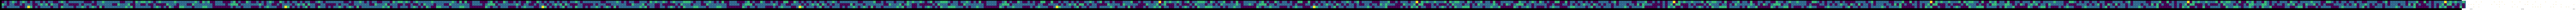

In [41]:
fig, ax = plt.subplots(figsize=(600,30))
im = ax.imshow(group_df.values, interpolation="nearest")

# We want to show all ticks...
ax.set_xticks(np.arange(len(group_df.columns), step=20))
ax.set_yticks(np.arange(len(group_df.index)))

# ax.set_xticklabels(np_xticks)
ax.set_xticklabels(np.array(group_df.columns)[subframes])

for i in range(len(group_df.values)):
    for j in range(len(group_df.values[i])):
        if group_df.values[i,j] == -1:
            text = ax.text(j, i, "HD", ha="center", va="center", color="red")
        elif group_df.values[i,j] == 0:
            text= ax.text(j, i, 0, ha="center", va="center", color="Orange")
        else:
            text = ax.text(j, i, group_df.values[i,j], ha="center", va="center", color="white")

# fig.tight_layout()
plt.gcf().set_facecolor("black")
# fig.set_size_inches(600, 100, forward=True)
plt.savefig("Message_history.svg")

In [42]:
merged_df.columns

Index(['EventNumber', 'Time', 'NodeID', 'cbr', 'grantStartTime', 'sciDecoded',
       'sciFailedHalfDuplex', 'sciNotDecoded', 'sciReceived', 'sciSent',
       'selectedNumSubchannels', 'selectedSubchannelIndex', 'senderID',
       'subchannelReceived', 'subchannelSent', 'subchannelsUsed',
       'subchannelsUsedToSend', 'tbDecoded', 'tbFailedButSCIReceived',
       'tbFailedDueToNoSCI', 'tbFailedHalfDuplex', 'tbReceived', 'tbSent',
       'txRxDistanceSCI', 'txRxDistanceTB', 'grantBreak'],
      dtype='object')

In [43]:
merged_df.head()

,EventNumber,Time,NodeID,cbr,grantStartTime,sciDecoded,sciFailedHalfDuplex,sciNotDecoded,sciReceived,sciSent,...,subchannelsUsedToSend,tbDecoded,tbFailedButSCIReceived,tbFailedDueToNoSCI,tbFailedHalfDuplex,tbReceived,tbSent,txRxDistanceSCI,txRxDistanceTB,grantBreak
1400151,10600504.0,502.0,0,0.727273,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400152,10600505.0,502.0,1,0.727273,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400153,10600506.0,502.0,2,0.739583,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400154,10600507.0,502.0,3,0.727273,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400155,10600508.0,502.0,4,0.727273,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
grant_request_df = merged_df[(merged_df["grantStartTime"] > 0)][["Time", "NodeID", "grantStartTime", "selectedSubchannelIndex"]]

In [45]:
grant_request_df["grantStartTime"] = grant_request_df["grantStartTime"].round(3)

In [46]:
grant_request_df.shape

(1010, 4)

In [47]:
group = grant_request_df.sort_values("grantStartTime")

In [48]:
duplicateRowsDF = grant_request_df[grant_request_df.duplicated(['grantStartTime', "selectedSubchannelIndex"], keep=False)]

In [49]:
duplicateRowsDF = duplicateRowsDF.sort_values("grantStartTime")

In [50]:
duplicateRowsDF.count()

Time                       98
NodeID                     98
grantStartTime             98
selectedSubchannelIndex    98
dtype: int64

In [51]:
grant_request_df.shape

(1010, 4)

In [52]:
duplicateRowsDF.shape

(98, 4)

In [53]:
group_df[group_df==1].count().sum()

1517

In [54]:
merged_df[merged_df["tbSent"] > 0]["tbSent"].sum()

25210.0

In [55]:
(23698/10)/10

236.98000000000002

In [56]:
(236.98/300) * 100

78.99333333333333

In [57]:
temp_df = grant_request_df

In [58]:
temp_df["grantStartTime"] = temp_df["grantStartTime"].astype(str)

In [59]:
temp_df.head()

,Time,NodeID,grantStartTime,selectedSubchannelIndex
1422572,502.005387,94,502.018,2.0
1427030,502.012738,178,502.04,0.0
1436850,502.026407,50,502.041,1.0
1440625,502.030643,190,502.069,2.0
1444656,502.035304,174,502.092,0.0


In [60]:
temp_df["grantStartTime"] = temp_df["grantStartTime"].str[5:]

In [61]:
temp_df.head()

,Time,NodeID,grantStartTime,selectedSubchannelIndex
1422572,502.005387,94,18,2.0
1427030,502.012738,178,4,0.0
1436850,502.026407,50,41,1.0
1440625,502.030643,190,69,2.0
1444656,502.035304,174,92,0.0


In [62]:
temp_df.head()

,Time,NodeID,grantStartTime,selectedSubchannelIndex
1422572,502.005387,94,18,2.0
1427030,502.012738,178,4,0.0
1436850,502.026407,50,41,1.0
1440625,502.030643,190,69,2.0
1444656,502.035304,174,92,0.0


In [63]:
duplicateRowsDF = grant_request_df[grant_request_df.duplicated(['grantStartTime', "selectedSubchannelIndex"], keep=False)]

In [64]:
duplicateRowsDF.sort_values(["grantStartTime", "Time"])

,Time,NodeID,grantStartTime,selectedSubchannelIndex
2381215,502.971252,120,,0.0
3995478,504.902461,166,,0.0
4623636,505.598841,201,,2.0
6425883,507.632165,100,,1.0
6487474,507.699490,89,,1.0
6790800,508.041444,38,,2.0
7436166,508.768551,212,,2.0
7475286,508.803718,25,,0.0
9135988,510.676900,17,,0.0
10000720,511.629302,87,,1.0
